In [1]:
# In this document, we check how much we can improve the classifier for OffTopic by including the original
# article.
# We do this by adding to the dense-word-embedding given by spacy the maximum similarity of the post with
# any paragraph of the article, based on the assumption that an offtopic post should have low similarity
# to any subsection of the article.

import re

import _sqlite3
import matplotlib
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm, naive_bayes
import sklearn
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

In [2]:

nlp = spacy.load("de_core_news_lg")
cnx = _sqlite3.connect("corpus.sqlite3")


In [3]:
# Eventuell notwendige, einmalige Installation der Spacy-Pipeline:
# !python -m spacy download de_core_news_lg

In [4]:
# comments_df = pd.read_sql_query("Select ID_Post, Headline, Body FROM Posts",cnx)
# labels_df = pd.read_sql_query("SELECT * From Annotations_consolidated",cnx)


In [ ]:
labels = ["ArgumentsUsed","Discriminating","Inappropriate","OffTopic","PersonalStories","PossiblyFeedback","SentimentNegative","SentimentNeutral","SentimentPositive"]

label_map = {y:x for (x,y) in enumerate(labels)}


In [13]:
pd.read_sql_query("WITH OffTopicLabeledPosts AS ("
                  "Select ID_Post, Headline, Body, Value,ID_Article "
                  "FROM Posts INNER JOIN Annotations_consolidated USING(ID_Post)"
                  "WHERE Annotations_consolidated.Category = 'OffTopic'),"
                  "ArticlesDeduplicated AS "
                  "(SELECT ID_Article, Body "
                  "FROM Articles)"
                  "SELECT ID_Post,Headline,OffTopicLabeledPosts.Body AS PostBody,ArticlesDeduplicated.Body AS ArticleBody,Value "
                  "FROM OffTopicLabeledPosts INNER JOIN ArticlesDeduplicated USING(ID_Article)",cnx)

,ID_Post,Headline,PostBody,ArticleBody,Value
0,3326,None,Top qualifizierte Leute verdienen auch viel.,"<div class=""section"" id=""content-main"" itempro...",0
1,5321,None,"Gott sei dank ist für sie eine Umfrage alles, ...","<div class=""section"" id=""content-main"" itempro...",0
2,5590,""" Die FPÖ wird aus allen Rohren schießen und d...","Sorry, aber die FPÖ tut eigentlich gar nichts ...","<div class=""section"" id=""content-main"" itempro...",0
3,6015,None,Weil es dein meisten Leuten verständlicherweis...,"<div class=""section"" id=""content-main"" itempro...",0
4,8213,None,Na wer weis was da vorgefallen ist...,"<div class=""section"" id=""content-main"" itempro...",0
...,...,...,...,...,...
3594,1004115,None,Russland ist in wk1 vorzeirig ausgestiegen. ;-...,"<div class=""section"" id=""content-main"" itempro...",0
3595,1004189,None,"Was tendenziell kein schlechter Tausch wäre, w...","<div class=""section"" id=""content-main"" itempro...",1
3596,1004571,None,Was? Unsinn! Der Linguistik turn beschränkt si...,"<div class=""section"" id=""content-main"" itempro...",0
3597,1006462,"wien verschreckt investoren, wenn sie trotz po...",wahrscheinlich läuft es auf schmiergeldzahlung...,"<div class=""section"" id=""content-main"" itempro...",0


In [16]:
def getLabeledPartOfftopic():
    """

    :param label: Das Label, so dass wir alle Posts auswählen, bei denen dieses Label gesetzt ist
    :return: Ein DataFrame mit dem Index ID_Post (als 0. Spalte) und den Spalten 'Text' sowie 'Value'.
             'Value' besagt hierbei für jeden Post, ob das Label zutrifft oder nicht (1 oder 0)
    """


    # Wir holen uns alle Posts, die gemäß dem Parameter OffTopic gelabelt sind.
    #
    wanted_join_table = pd.read_sql_query("WITH OffTopicLabeledPosts AS ("
                                          "Select ID_Post, Headline, Body, Value,ID_Article "
                                          "FROM Posts INNER JOIN Annotations_consolidated USING(ID_Post)"
                                          "WHERE Annotations_consolidated.Category = 'OffTopic'),"
                                          "ArticlesDeduplicated AS "
                                          "(SELECT ID_Article, Body "
                                          "FROM Articles)"
                                          "SELECT ID_Post,Headline,OffTopicLabeledPosts.Body AS PostBody,ArticlesDeduplicated.Body AS ArticleBody,Value "
                                          "FROM OffTopicLabeledPosts INNER JOIN ArticlesDeduplicated USING(ID_Article)",cnx)


    # Setzen ID_Post als Index des DataFrames
    wanted_join_table = wanted_join_table.set_index("ID_Post")

    # Erzeugen der gewünschten Output-Spalte
    wanted_join_table["Similarity"]= None
    wanted_join_table["Similarity"]= wanted_join_table["Similarity"].astype(object)

    # Fusen von Headline & Body
    for row_ID, cur_row in wanted_join_table.iterrows():
        headline = cur_row["Headline"]
        body = cur_row["PostBody"]
        if not headline:
            wanted_join_table.loc[row_ID,"Text"] = cur_row["PostBody"]
        elif not body:
            wanted_join_table.loc[row_ID,"Text"] = cur_row["Headline"]
        else:
            wanted_join_table.loc[row_ID,"Text"] = cur_row["Headline"] +"\n"+ cur_row["PostBody"]


        sim =0
        nlp_of_text = nlp(wanted_join_table.loc[row_ID,"Text"])
        for paragraph in re.findall("<p>(.*?)</p>",wanted_join_table.loc[row_ID,"ArticleBody"]):
            #Entfernen von HTML-Content (nur einfaches HTML der Form <...>)
            cleantext = re.sub("<.*?>", ' ', paragraph)

            # Nach cleanen: Ist mindestens einer der Meaning-Vektoren (gemäß Word2Vec) des Posts
            # Nahe an dem des Posts? Wir speichern den minimalen Abstand d(post,article):
            calc_sim = nlp_of_text.similarity(nlp(cleantext))
            sim = max(sim,calc_sim)

        j = nlp_of_text.vector
        arr = np.array(list(j)+[sim])
        wanted_join_table.loc[row_ID,"Similarity"] = [[arr]]


    wanted_join_table = wanted_join_table\
        .drop("Headline",axis=1)\
        .drop("PostBody",axis=1)\
        .drop("ArticleBody",axis=1)\
        .drop("Text",axis=1)

    return wanted_join_table


In [19]:
#Einmalige Vorab-Berechnung der Tabelle:
joined_table = getLabeledPartOfftopic()
joined_table

C:\Users\Sanitiy\AppData\Local\Temp\ipykernel_6792\3286136857.py:50: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  calc_sim = nlp_of_text.similarity(nlp(cleantext))


In [34]:
inter = np.array(joined_table[["Similarity"]].values.tolist()).reshape((3599,301))
joined_table = np.column_stack((joined_table[["Value"]],inter))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [39]:
joined_table

array([[ 0.00000000e+00,  8.68638575e-01, -1.26829433e+00, ...,
         1.77004302e+00,  7.06160009e-01,  6.09662355e-01],
       [ 0.00000000e+00,  2.59616828e+00, -4.56688017e-01, ...,
         2.65285707e+00,  2.25746655e+00,  7.57919989e-01],
       [ 0.00000000e+00,  1.26443768e+00, -7.37381876e-02, ...,
         2.93036842e+00,  3.58501881e-01,  9.23555453e-01],
       ...,
       [ 0.00000000e+00,  1.14167368e+00, -1.75747648e-03, ...,
         3.26374269e+00,  1.17367887e+00,  8.41805144e-01],
       [ 0.00000000e+00,  1.55016494e+00, -7.77563989e-01, ...,
         2.03774548e+00,  9.23568428e-01,  8.74383007e-01],
       [ 1.00000000e+00,  2.24676728e+00, -1.22532809e+00, ...,
         2.65296173e+00,  1.35278630e+00,  6.92698608e-01]])

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



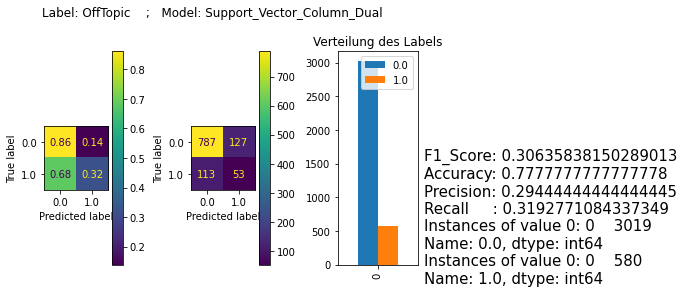

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



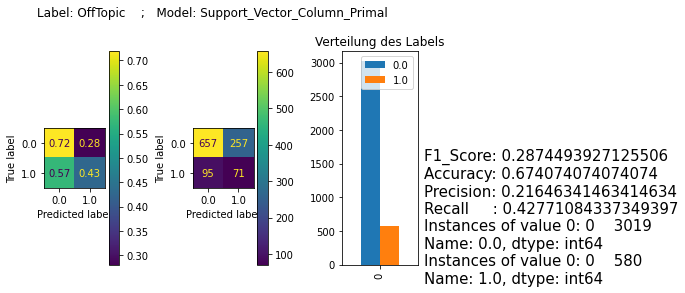

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



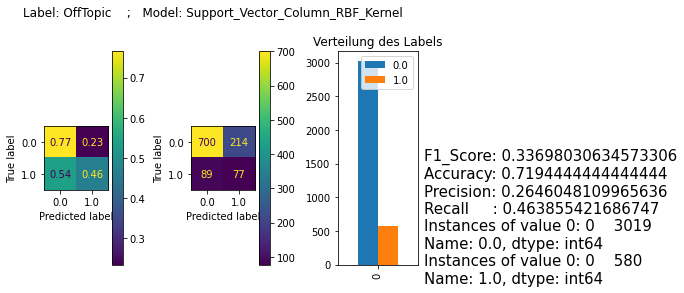

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



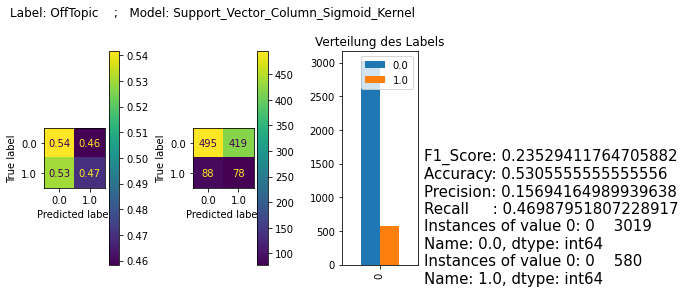

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



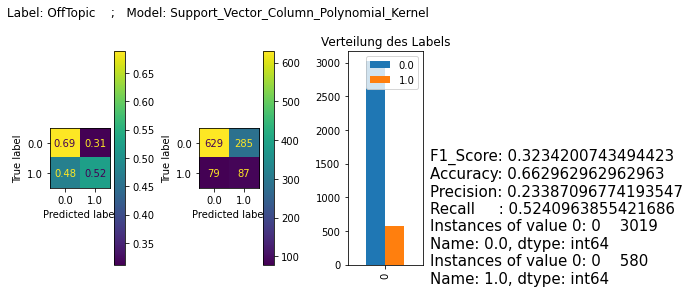

--------------


In [43]:
from collections import Counter

# Versuch 1:
# Lernen jedes Labels als binäres Label.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.
for label in ["OffTopic"]:
    # Table_Join holen:


    #Splitten in Test & Trainingsdatensätze:
    text_train, text_test, label_train, label_test = train_test_split(joined_table[:,1:], joined_table[:,0],
                                                                          test_size=0.3,
                                                                          random_state=1234, shuffle=True)



    model_names = ["Support_Vector_Column_Dual","Support_Vector_Column_Primal","Support_Vector_Column_RBF_Kernel","Support_Vector_Column_Sigmoid_Kernel","Support_Vector_Column_Polynomial_Kernel"]
    models = [svm.LinearSVC(class_weight = "balanced"),
              svm.LinearSVC(dual= False,class_weight = "balanced"),
              svm.SVC(class_weight = "balanced"),
              svm.SVC(kernel="sigmoid",class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=3,class_weight = "balanced")]
    for model,model_name in zip(models,model_names):
        # Transposed the matrices in the input because calculating text_train takes so long, and I didn't want to recalculate it.

        #Trainieren des Modells:
        model.fit(text_train,label_train)

        #Vom trainierten Modell geschätzte Labels des Testdatensatzes:
        model_predictions = model.predict(text_test)

        # Verteilung der Instanzen auf das Label (d.h. wie viele 0-Instanzen und wie viele 1-Instanzen gibt es)
        counts_dict = Counter(joined_table[:,0])
        val_counts = pd.DataFrame({x:[counts_dict[x]] for x in (counts_dict)})

        print("--------------")
        print("--------------")
        print("Label:    {}".format(label))


        print("--------------")
        print("{}:".format(model_name))

        print("Confusion Matrix: \n")
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
        fig.suptitle(("Label: {}    ;   Model: {}".format(label,model_name)))
        classifier_evaluation = ("F1_Score: "+  str(sklearn.metrics.f1_score       (label_test, model_predictions))+ "\n"+
                                "Accuracy: "+  str(sklearn.metrics.accuracy_score (label_test, model_predictions))+ "\n"+
                                "Precision: "+ str(sklearn.metrics.precision_score(label_test, model_predictions))+ "\n"+
                                "Recall     : "+    str(sklearn.metrics.recall_score   (label_test, model_predictions))+ "\n"+
                                "Instances of value 0: "+str(val_counts[0]) +"\n"+ "Instances of value 0: "+str(val_counts[1]))
        # ax1.annotate( classifier_evaluation, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top',fontsize = 18)
        #Alternative Variante
        plt.figtext(0.99, 0.01, classifier_evaluation, horizontalalignment='left', verticalalignment ="bottom", fontsize = 15)
        conf_matrix_normalized = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions, normalize="true",ax= ax1)
        conf_matrix = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions,ax= ax2)
        bar_plot = val_counts.plot.bar(ax = ax3,title = "Verteilung des Labels")
        fig.tight_layout()
        plt.show()


        print("--------------")




C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 

--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 

--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 

--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 

--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 

--------------


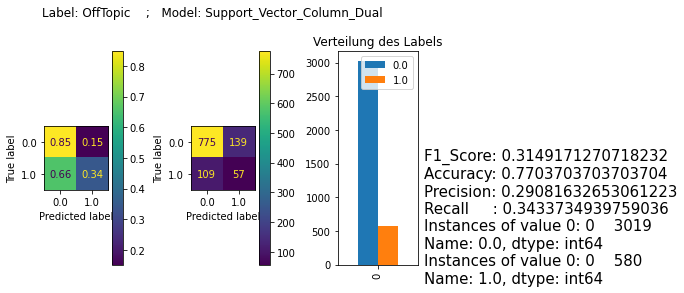

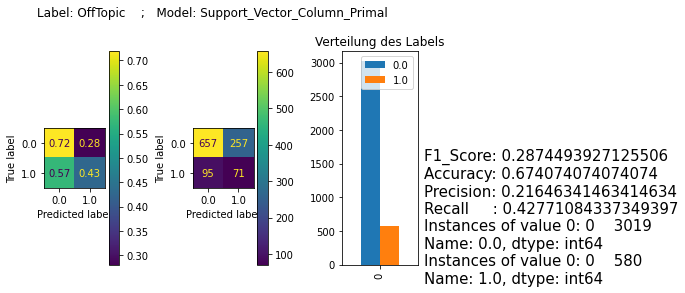

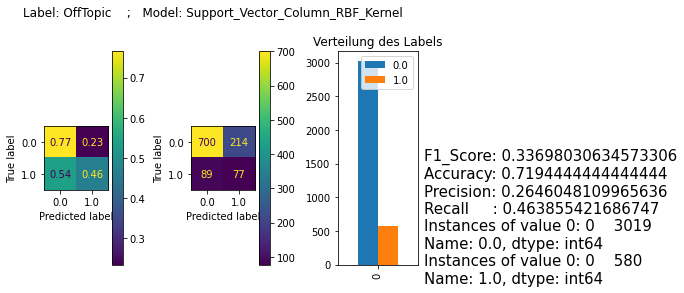

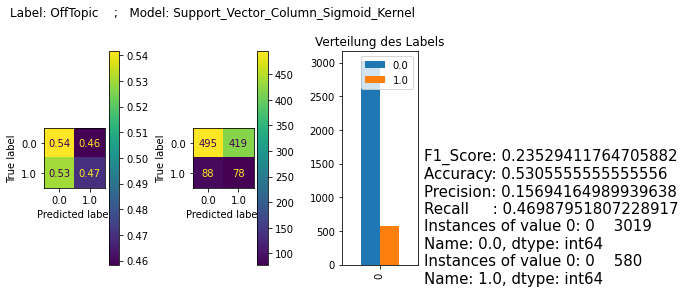

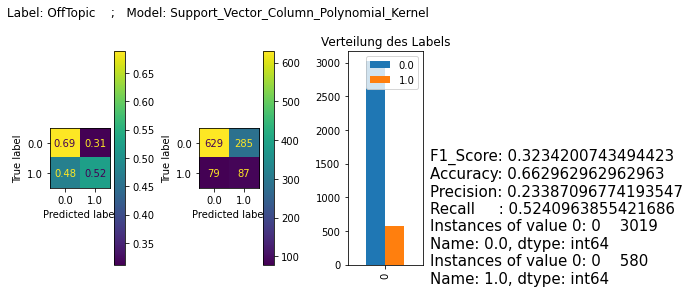

In [44]:
# Versuch 1 Erweiterung: Direktes Speichern als PDF statt als Output-Text

from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter
pdf_out = PdfPages('Best_lg_using_article_OffTopic.pdf')
# Versuch 1:
# Lernen jedes Labels als binäres Label.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.
for label in ["OffTopic"]:
    # Table_Join holen:


    #Splitten in Test & Trainingsdatensätze:
    text_train, text_test, label_train, label_test = train_test_split(joined_table[:,1:], joined_table[:,0],
                                                                      test_size=0.3,
                                                                      random_state=1234, shuffle=True)



    model_names = ["Support_Vector_Column_Dual","Support_Vector_Column_Primal","Support_Vector_Column_RBF_Kernel","Support_Vector_Column_Sigmoid_Kernel","Support_Vector_Column_Polynomial_Kernel"]
    models = [svm.LinearSVC(class_weight = "balanced"),
              svm.LinearSVC(dual= False,class_weight = "balanced"),
              svm.SVC(class_weight = "balanced"),
              svm.SVC(kernel="sigmoid",class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=3,class_weight = "balanced")]
    for model,model_name in zip(models,model_names):
        # Transposed the matrices in the input because calculating text_train takes so long, and I didn't want to recalculate it.

        #Trainieren des Modells:
        model.fit(text_train,label_train)

        #Vom trainierten Modell geschätzte Labels des Testdatensatzes:
        model_predictions = model.predict(text_test)

        # Verteilung der Instanzen auf das Label (d.h. wie viele 0-Instanzen und wie viele 1-Instanzen gibt es)
        counts_dict = Counter(joined_table[:,0])
        val_counts = pd.DataFrame({x:[counts_dict[x]] for x in (counts_dict)})

        print("--------------")
        print("--------------")
        print("Label:    {}".format(label))


        print("--------------")
        print("{}:".format(model_name))

        print("Confusion Matrix: \n")
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
        fig.suptitle(("Label: {}    ;   Model: {}".format(label,model_name)))
        classifier_evaluation = ("F1_Score: "+  str(sklearn.metrics.f1_score       (label_test, model_predictions))+ "\n"+
                                 "Accuracy: "+  str(sklearn.metrics.accuracy_score (label_test, model_predictions))+ "\n"+
                                 "Precision: "+ str(sklearn.metrics.precision_score(label_test, model_predictions))+ "\n"+
                                 "Recall     : "+    str(sklearn.metrics.recall_score   (label_test, model_predictions))+ "\n"+
                                 "Instances of value 0: "+str(val_counts[0]) +"\n"+ "Instances of value 0: "+str(val_counts[1]))
        # ax1.annotate( classifier_evaluation, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top',fontsize = 18)
        #Alternative Variante
        plt.figtext(0.99, 0.01, classifier_evaluation, horizontalalignment='left', verticalalignment ="bottom", fontsize = 15)
        conf_matrix_normalized = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions, normalize="true",ax= ax1)
        conf_matrix = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions,ax= ax2)
        bar_plot = val_counts.plot.bar(ax = ax3,title = "Verteilung des Labels")
        fig.tight_layout()
        pdf_out.savefig(fig,bbox_inches='tight')


    print("--------------")

pdf_out.close()





In [ ]:
# Versuch 3: ON_HOLD - Es gibt zu wenig positive Ausprägungen...
# Die Labels "SentimentNegative","SentimentNeutral" und "SentimentPositive" können als Ausprägungen eines einzelnen Labels interpretiert werden.
# Zu beachten ist hierbei allerdings, dass einige Posts mehrere dieser Labels gleichzeitig haben.
# Wir können also einen Regressor bauen für den 0 - Negativ, 1 - Neutral, 2 - Positiv bedeutet.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.


In [17]:
joined_table = getLabeledPart(labels[0])
joined_table.loc[joined_table["Value"] == 0]

,Value,Text
ID_Post,,
3326,0,Top qualifizierte Leute verdienen auch viel.
6015,0,Weil es dein meisten Leuten verständlicherweis...
8213,0,Na wer weis was da vorgefallen ist...
9724,0,Gabalier?\r\nKünstler?\r\nBruahahaha!
12986,0,"Juhu, ich werde reich! :)\nVery Urgent Bastard..."
...,...,...
998656,0,bei der VOEST gab es seinerzeit den Anser-Wern...
1003433,0,"Aber nicht aus Rassismus, sondern aus Blödheit."
1004189,0,"Was tendenziell kein schlechter Tausch wäre, w..."


,Value,Text
ID_Post,,
5321,1,"Gott sei dank ist für sie eine Umfrage alles, ..."
5590,1,""" Die FPÖ wird aus allen Rohren schießen und d..."
6015,0,Weil es dein meisten Leuten verständlicherweis...
8213,0,Na wer weis was da vorgefallen ist...
9724,0,Gabalier?\r\nKünstler?\r\nBruahahaha!
...,...,...
76875,0,"Also, als er Geschenke gemacht hat und die Woh..."
76876,0,In den USA ist man als Sugarbaby auch einkomme...
76877,0,Diese attraktiven Schwedinen und ihr Gespühr f...


,ID_Post,Headline,Body,Body
0,3326,None,Top qualifizierte Leute verdienen auch viel.,"<div class=""section"" id=""content-main"" itempro..."
1,5321,None,"Gott sei dank ist für sie eine Umfrage alles, ...","<div class=""section"" id=""content-main"" itempro..."
2,5590,""" Die FPÖ wird aus allen Rohren schießen und d...","Sorry, aber die FPÖ tut eigentlich gar nichts ...","<div class=""section"" id=""content-main"" itempro..."
3,6015,None,Weil es dein meisten Leuten verständlicherweis...,"<div class=""section"" id=""content-main"" itempro..."
4,8213,None,Na wer weis was da vorgefallen ist...,"<div class=""section"" id=""content-main"" itempro..."
...,...,...,...,...
3594,1004115,None,Russland ist in wk1 vorzeirig ausgestiegen. ;-...,"<div class=""section"" id=""content-main"" itempro..."
3595,1004189,None,"Was tendenziell kein schlechter Tausch wäre, w...","<div class=""section"" id=""content-main"" itempro..."
3596,1004571,None,Was? Unsinn! Der Linguistik turn beschränkt si...,"<div class=""section"" id=""content-main"" itempro..."
3597,1006462,"wien verschreckt investoren, wenn sie trotz po...",wahrscheinlich läuft es auf schmiergeldzahlung...,"<div class=""section"" id=""content-main"" itempro..."


['<p>Michael Häupl schweigt noch hinsichtlich der Wahlergebnisse in der  Steiermark und im Burgenland. Der Wiener Bürgermeister möchte sich erst  bei seiner wöchentlichen Pressekonferenz am Dienstag zu den enormen  Zugewinnen der <a href="/r1528/FPOe">FPÖ</a> und den Verlusten von <a href="/r510/SPOe">SPÖ</a> und <a href="/r2578/OeVP">ÖVP</a> äußern. In der  Zwischenzeit muss sein Sprecher Martin Ritzmaier mit Erklärungsversuchen  aushelfen. Man werde nicht den Fehler machen, ins "allgemeine Gejammere"  einzustimmen, sagt er, aber man nehme das Ergebnis in beiden  Bundesländern sehr ernst. Man könne nicht die Augen davor verschließen,  dass die Emotion bei vielen dazu führe, das Kreuz bei der FPÖ zu machen.  In Wien hätten jedoch bereits bei der letzten Wahl fast 26 Prozent der  Wählerinnen und Wähler der FPÖ ihre Stimme gegeben, der Wähleraustausch  sei somit schon abgeschlossen. Zum Vergleich: Die SPÖ kam 2010 auf 44,3  Prozent.</p>',
 '<p>Das Wichtigste sei nun, die Wahlbeteiligung 

In [69]:
sim = 0.3
t = nlp("ie FPÖ signalisierte am Montag, für den Wahlkampf startklar zu  sein. Dass die Blauen den Rückenwind der Bundesländerergebnisse nutzen ")
(t.vector.shape)

(300,)

In [55]:
np.concatenate(([sim],t.vector))

array([ 0.3       ,  1.23216259,  0.93089503, -0.25961047, -0.30539334,
       -0.20930463,  0.11431701, -0.0971409 ,  0.5905782 ,  1.43681538,
        0.09366521, -1.93145037, -0.3161155 ,  0.80950147,  1.93384182,
       -0.57161927, -0.30754817, -1.29132056, -0.80088156, -1.80418134,
        0.65139633,  0.1776391 ,  1.99299812,  0.88857478, -1.51841271,
        0.4863756 ,  0.74191833,  0.33551285, -0.18548088,  0.49797747,
       -0.53360224, -1.90719223,  0.21928047,  0.84145319, -2.02472591,
       -0.02584476, -1.93485951, -1.66651154,  1.90337908,  0.52254456,
       -1.42036903, -0.70871454, -0.5199421 , -1.57892382,  0.87057966,
       -2.09581852,  1.06616104,  0.30628854,  1.00407505, -1.44167507,
        0.15611887, -2.89923286,  1.81796885,  0.46182364, -0.43806255,
       -0.75160998, -0.07518635,  2.03342438,  0.9878816 ,  0.42987931,
       -0.32423863, -0.02472191, -0.61372638, -0.25622228,  0.60260558,
        1.11036372,  1.06566739,  1.7964977 , -0.59756589,  1.44